In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import numpy as np
import os
from Utils.read_coord import kml_coord
from Utils.sentinal_request import senti_api
from Utils.forest_cover import get_cover
from utils import plot_image
from Utils.forest_cover import get_cover,green_cover_plot,green_cover_plot2, green_cover_plot_smooth
from Utils.carbon_seq_cal.seques_forecast import cal_existing
from Utils.carbon_seq_cal.forecast import plot_SEQ,growth_chart
from Utils.map_view import map_show
from Utils.tree_count import count_trees
from Utils.tree_count import tree_count
import webbrowser
from Utils import tree_models as tree_model
from Utils.carbon_seq_cal import def_allometric_AGB_multi_model_New as allometric_cal
from PIL import Image, ImageFilter
import earthpy.plot as ep
import matplotlib.pyplot as plt


In [29]:
kml_file_name = input('Enter kml name: ')

file_path = os.path.join(os.getcwd(), 'test_kml_files', kml_file_name )
print("The KML file path:",file_path, end="")
if os.path.exists(file_path):
    print(' Exists')
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()
else:
    print(' The specified file does NOT exist')

# getting polygon coordinates
poly_coord = kml_coord(file_path)

Enter kml name: Kolonnawa.kml
The KML file path: C:\Users\DELL\Documents\GitHub\SPE\SPE-testing\test_kml_files\Kolonnawa.kml Exists


In [30]:
kml_file_name_no_ext = kml_file_name.split(".")[0]
dat_file_name = kml_file_name_no_ext + '.npy'
file_path_to_sat_img = os.path.join( os.getcwd(), 'kml_to_ndarray', dat_file_name )

img = None
print(file_path_to_sat_img)
if os.path.exists(file_path_to_sat_img):
    print('Sat ndarray image exist already')
    # img = np.fromfile(file_path_to_sat_img, dtype=float)
    img = np.load(file_path_to_sat_img)
    resol = 10

else:
    print("NeW KML file uploaded; ping to API")        
    img,resol = senti_api(poly_coord)
    # img.tofile(file_path_to_sat_img)
    np.save(file_path_to_sat_img, img) 

C:\Users\DELL\Documents\GitHub\SPE\SPE-testing\kml_to_ndarray\Kolonnawa.npy
Sat ndarray image exist already


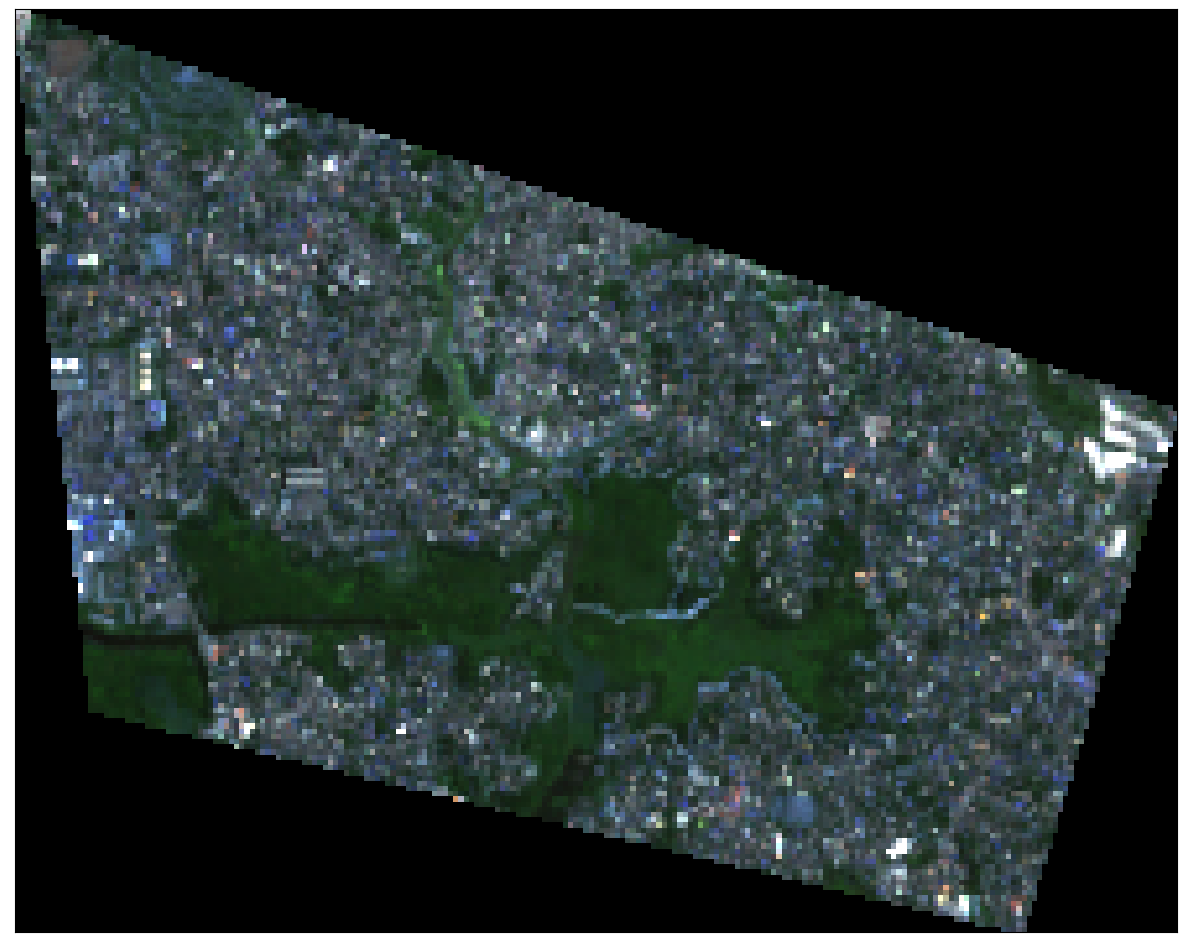

In [31]:
#visualize RGB
plot_image(img[:, :, [0, 1, 2]], factor=3.5, clip_range=(0, 1))

In [5]:
# show the map view
map_show(poly_coord)

In [32]:
while True:
    user_input = input('What type of forestration? (Pick 1 for Temperate Forest/ 2 for Tropical Rain Forests/ 3 for Coastal Forest): ')
    if user_input.lower() == '1':
        print('user typed Temperate Forest')
        lo_thresh = 0.31
        up_thresh = 0.77
        break

    elif user_input.lower() == '2':
        print('user typed Tropical Rain Forests')
        lo_thresh = 0.80
        up_thresh = 0.92
        break
    
    elif user_input.lower() == '3':
        print('user typed Coastal Forest')
        lo_thresh = 0.64
        up_thresh = 0.77
        break
    else:
        print('Type not recognized')

What type of forestration? (Pick 1 for Temperate Forest/ 2 for Tropical Rain Forests/ 3 for Coastal Forest): 2
user typed Tropical Rain Forests


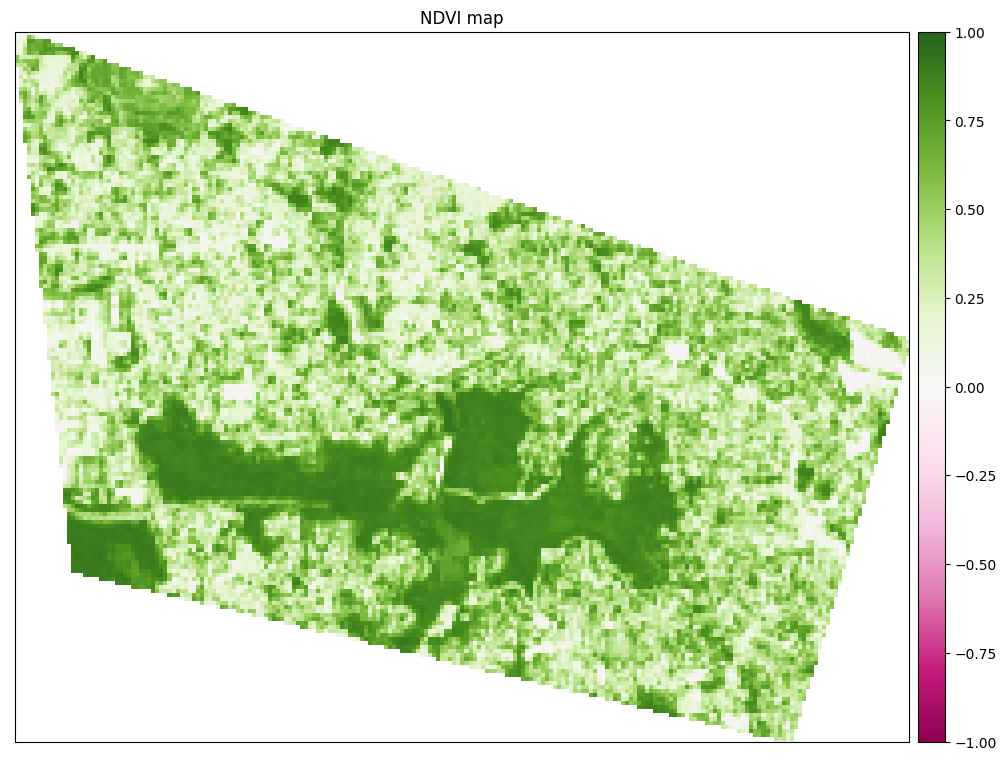

In [33]:
# Plot the NDVI
NDVI_bounds = tree_model.NDVI_threasholds(lo_thresh, up_thresh)

forest_area,forest_cover,green_pixel,green_cov,ndvi, ndvi_d, cloud_cover = get_cover(img,resol,NDVI_bounds.lower_bound, NDVI_bounds.upper_bound)

ep.plot_bands(ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="NDVI map")
plt.show()

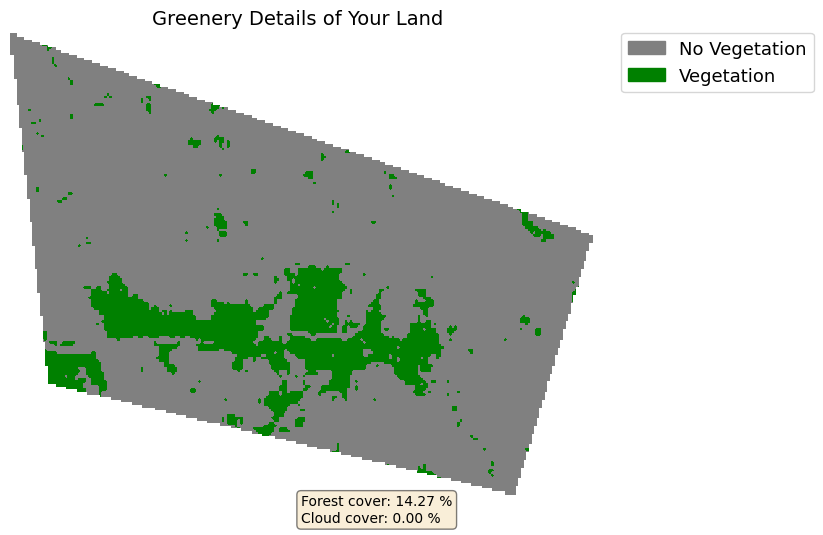

In [34]:
fig = green_cover_plot(ndvi,ndvi_d,forest_cover,cloud_cover)
fig.show()


In [20]:
species_type = input('Enter the existing species type ( broadLeavedSpecies/ ConiferousSpecies/ ConiferousTaxodiumDistichumSpecies/ PalmSpecies): ')
count_exist = input('Enter the existing tree count: ')
count_exist = int(count_exist)
region_type = input('Enter the region type(tropicalDryRegions/tropicalHumidRegion/tropicalWetRegion): ')
annual_rainfall = input('Enter the Annual rainfall in mm: ')
annual_rainfall = int(annual_rainfall)

#age_exist = input('Enter the age of the plantation: ')
#age_exist = int(age_exist)

DBH_cm = input('Enter the avg DBH of the Plants in cm: ')
DBH_cm = int(DBH_cm)

Height_m = input('Enter the avg Height of the Plants in m: ')
Height_m = int(Height_m)

Enter the existing species type ( broadLeavedSpecies/ ConiferousSpecies/ ConiferousTaxodiumDistichumSpecies/ PalmSpecies): ConiferousSpecies
Enter the existing tree count: 1
Enter the region type(tropicalDryRegions/tropicalHumidRegion/tropicalWetRegion): tropicalDryRegions
Enter the Annual rainfall in mm: 899
Enter the avg DBH of the Plants in cm: 15
Enter the avg Height of the Plants in m: 30


In [41]:
'''
species_type = "broadLeavedSpecies"
count_exist = 1
region_type = "tropicalDryRegions"
annual_rainfall = 899
DBH_cm = 15
Height_m = 30
'''

In [42]:
tree_land_spec = tree_model.tree_geo_specifications(    tree_model.species_category[species_type],
                                                        tree_model.region_type[region_type],
                                                        annual_rainfall,
                                                        DBH_cm,
                                                        Height_m
                                                    ) 

annual_rainFall_category = None
dbh_category = None
print(tree_land_spec.species_general_type.name)
print(tree_land_spec.region.name)

# once finalised this can be further simplified using binning

# defining Rainfall categories
if 0 <= tree_land_spec.annual_rainfall < 900:
    annual_rainFall_category = 'le900'

elif 900 <= tree_land_spec.annual_rainfall < 1500:
    annual_rainFall_category = '900To1500'
    
elif 1500 <= tree_land_spec.annual_rainfall < 4000:
    annual_rainFall_category = '1500To4000'
    
else:
    annual_rainFall_category = 'Gr4000'   

# Nested functions for C-seq calculation
if tree_land_spec.species_general_type.name == "broadLeavedSpecies":

    if annual_rainFall_category == 'le900':

        if 3 <= tree_land_spec.dbh_cm <= 30:
            dbh_category = '3To30'

    elif annual_rainFall_category == '900To1500':

        if 5 <= tree_land_spec.dbh_cm <= 40:
            dbh_category = '5To40'

    elif annual_rainFall_category == '1500To4000':

        if tree_land_spec.dbh_cm < 60:
            dbh_category = 'le60'

        elif 60 <= tree_land_spec.dbh_cm <= 148:
            dbh_category = '6To148'
    else:

        if 4 <= tree_land_spec.dbh_cm <= 112:
            dbh_category = '4To112'

if tree_land_spec.species_general_type.name == "ConiferousSpecies": 
    
    annual_rainFall_category = 'notKnown'
    tree_land_spec.region = 'notKnown'
    
    if 2 <= tree_land_spec.dbh_cm <= 52:
        dbh_category = '2To52'
        
if tree_land_spec.species_general_type.name == "ConiferousTaxodiumDistichumSpecies": 
    
    annual_rainFall_category = 'notKnown'
    dbh_category = 'notKnown'
    tree_land_spec.region = 'notKnown'
       
        
if tree_land_spec.species_general_type.name == "PalmSpecies":
    
    annual_rainFall_category = 'notKnown'
    tree_land_spec.region = 'notKnown'
    
    if tree_land_spec.dbh_cm > 7.5:
        dbh_category = 'Gr7point5'
        

print(tree_land_spec)
print(tree_land_spec.species_general_type.name)
print(tree_land_spec.region)
print(annual_rainFall_category)
print(dbh_category)

if tree_land_spec.species_general_type.name in ["ConiferousSpecies","ConiferousTaxodiumDistichumSpecies","PalmSpecies"]:
    function_name = tree_land_spec.species_general_type.name + '_' + \
                    tree_land_spec.region  + '_' +\
                    annual_rainFall_category + '_' +\
                    dbh_category
    
else:
    function_name = tree_land_spec.species_general_type.name + '_' + \
                tree_land_spec.region.name  + '_' +\
                annual_rainFall_category + '_' +\
                dbh_category

if (hasattr(allometric_cal, function_name)) :
    print("Selected Function:",function_name)
    above_ground_biomass_kg = getattr(allometric_cal, function_name)(tree_land_spec, count_exist)
else:
    print("Looks like specific function not implemented or Not enough information")
    print("Switch to basic calculation")
    above_ground_biomass_kg = allometric_cal.notKnown_notKnown_notKnown_notKnown(tree_land_spec, count_exist)

AGB_general_method = allometric_cal.notKnown_notKnown_notKnown_notKnown(tree_land_spec, count_exist)

print("C Seq Specific: ", round(above_ground_biomass_kg/1e3,4), 'T Vs General: ', round(AGB_general_method/1e3,2), 'T' )
print("C Seq Specific: ", round(above_ground_biomass_kg,4), 'kg Vs General: ', round(AGB_general_method,2), 'kg' )

ConiferousSpecies
tropicalDryRegions
tree_geo_specifications(species_general_type=<species_category.ConiferousSpecies: 1>, region='notKnown', annual_rainfall=899, dbh_cm=15, height_m=30)
ConiferousSpecies
notKnown
notKnown
2To52
Selected Function: ConiferousSpecies_notKnown_notKnown_2To52
C Seq Specific:  0.0482 T Vs General:  0.14 T
C Seq Specific:  48.1929 kg Vs General:  141.1 kg


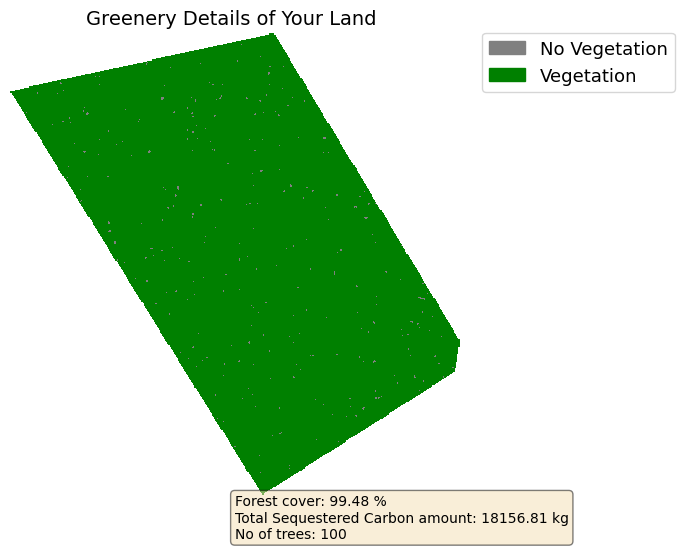

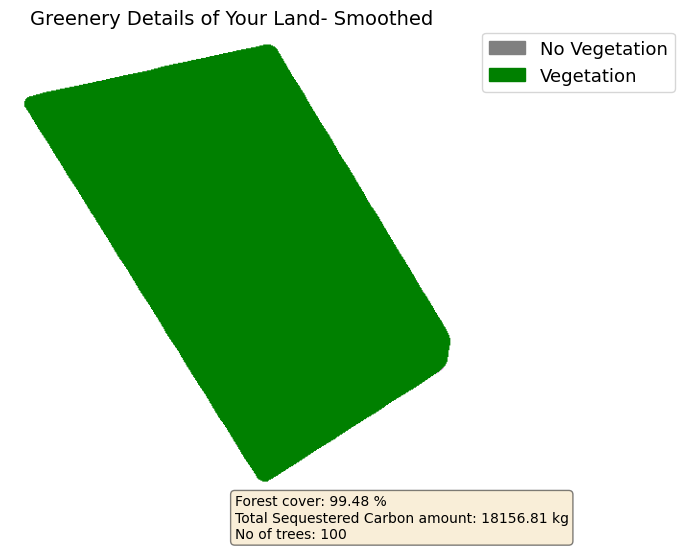

In [61]:
fig2 = green_cover_plot2(ndvi,ndvi_d,forest_cover,count_exist,above_ground_biomass_kg)
fig3 = green_cover_plot_smooth(ndvi,ndvi_d,forest_cover,count_exist,above_ground_biomass_kg,kml_file_name_no_ext)


In [38]:
tree_type = input('Enter the type of the new tree: ')

t_count = input('Enter no of trees: ')
t_count = int(t_count)

age_max = input('Enter the max age: ')
age_max = int(age_max)


Enter the type of the new tree: Rubber
Enter no of trees: 100
Enter the max age: 20


broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500_5To40
broadLeavedSpecies_tropicalWetRegion_900To1500

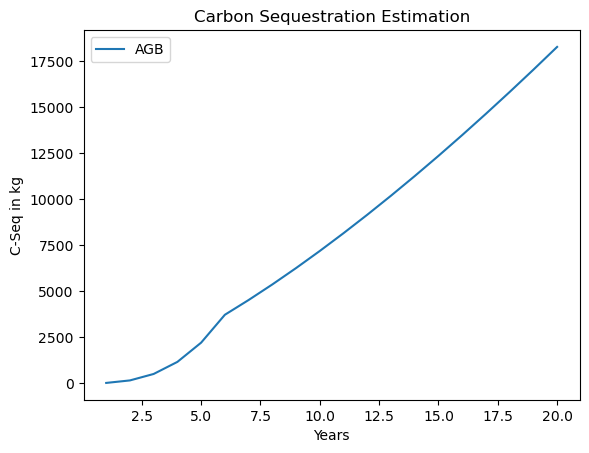

In [49]:
#growth chart filtered by max age
chart = growth_chart(age_max,tree_type).reset_index() 

ag_biomass = []
general =[]
for index,row in chart.iterrows():
    
    tree_land_spec.height_m = row["Height "]
    tree_land_spec.dbh_cm = row["DBH "]
    if 0 <= tree_land_spec.dbh_cm < 40:
        dbh_category = '5To40'
    
    elif 40 <= tree_land_spec.dbh_cm < 60:
        dbh_category = '40To60'
    #print(type(tree_land_spec.species_general_type.name),type(tree_land_spec.region.name),type(annual_rainFall_category),dbh_category)

    function_name = tree_land_spec.species_general_type.name + '_' + \
                    tree_land_spec.region.name  + '_' +\
                    annual_rainFall_category + '_' +\
                    dbh_category                    
    print(function_name)
    #function_name = 'broadLeavedSpecies_tropicalHumidRegion_le1500_5To40'
    if (hasattr(allometric_cal, function_name)) :
        #print("Selected Function:",function_name)
              
        above_ground_biomass_kg = getattr(allometric_cal, function_name)(tree_land_spec, t_count)
        ag_biomass.append(above_ground_biomass_kg)
    else:
        
        #print("Looks like specifi function not implemented or Not enough information")
        #print("Switch to basic calculation")
        above_ground_biomass_kg = allometric_cal.notKnown_notKnown_notKnown_notKnown(tree_land_spec, t_count)
        ag_biomass.append(above_ground_biomass_kg)
        
    AGB_general_method = allometric_cal.notKnown_notKnown_notKnown_notKnown(tree_land_spec, t_count)
    general.append(AGB_general_method)
gen = chart.copy()
chart.insert(0, "AGB",ag_biomass )
gen.insert(0, "AGB",general )
#print(chart)
#print(gen)
plot = plot_SEQ(chart)

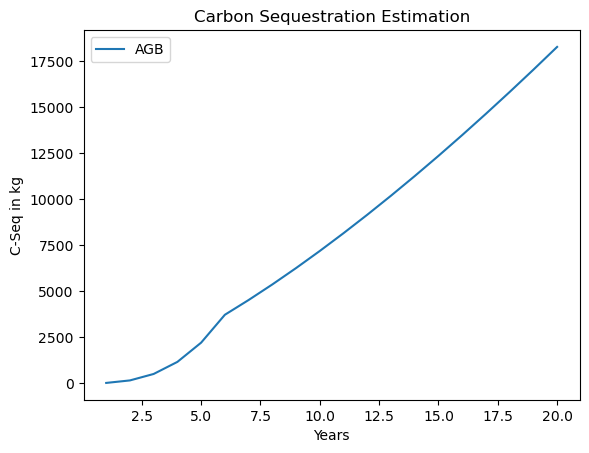

In [50]:
plot = plot_SEQ(gen)